In [32]:
import dicom
import inspect
import pylab
import numpy as np
from glob import glob
import os

import matplotlib
import matplotlib.pyplot as plt

from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator

import math
from sys import stdout

from utils.preprocess import *
from utils.data_manager import *
from skimage import measure, morphology
from scipy import ndimage

In [40]:
stats={}

In [124]:
stats['missed'] = []
for file in sorted(glob('data/*')):
    fcontent = np.load(file)
    mask_3d= fcontent.all()['mask']
    dilated = ndimage.binary_dilation(mask_3d, iterations=1)
    roi = ndimage.binary_dilation(fcontent.all()['tag'][:,:,:,ROI], iterations=1)
    covered = np.sum(dilated & roi) / np.sum(dilated)
    if (covered < 0.9):
        stats['missed'].append({'filename':file, 'coverage': covered})
    print('file %s mask cover %.2f%%' % (file, covered))

file data/benign001.npy mask cover 1.00%
file data/benign002.npy mask cover 1.00%
file data/benign003.npy mask cover 1.00%
file data/benign004.npy mask cover 1.00%
file data/benign005.npy mask cover 1.00%
file data/benign006.npy mask cover 1.00%
file data/benign007.npy mask cover 1.00%
file data/benign008.npy mask cover 0.72%
file data/benign009.npy mask cover 1.00%
file data/benign010.npy mask cover 1.00%
file data/benign011.npy mask cover 1.00%
file data/benign012.npy mask cover 0.68%
file data/benign013.npy mask cover 1.00%
file data/benign014.npy mask cover 1.00%
file data/benign015.npy mask cover 1.00%
file data/benign016.npy mask cover 1.00%
file data/benign017.npy mask cover 1.00%
file data/benign018.npy mask cover 0.98%
file data/benign019.npy mask cover 1.00%
file data/benign020.npy mask cover 1.00%
file data/benign021.npy mask cover 0.99%
file data/benign022.npy mask cover 1.00%
file data/benign023.npy mask cover 1.00%
file data/benign024.npy mask cover 0.99%
file data/benign

KeyboardInterrupt: 

In [99]:
def inspect():
    for missed in stats['missed']:
        fcontent = np.load(missed)
        mask_3d= fcontent.all()['mask']
        dilated = ndimage.binary_dilation(mask_3d, iterations=2)
        roi = fcontent.all()['tag'][:,:,:,ROI]
        yield missed, mask_3d, roi

In [100]:
gen = inspect()

data/benign012.npy


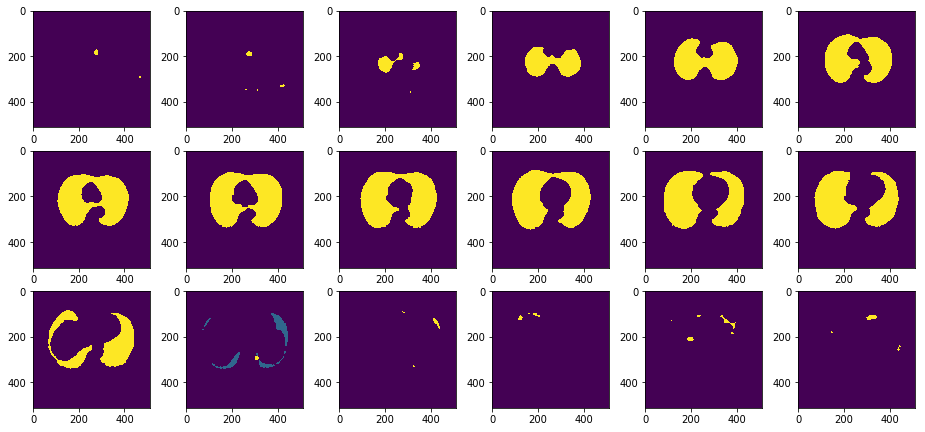

In [102]:
missed, mask, roi = next(gen)
num_slices = mask.shape[0]
plt.figure(figsize=(16, 12*((num_slices-1) / 6) + 12))
print(missed)
for i in range(num_slices):
    image = ((mask[i]>0) * 3) + (roi[i] * 1)
    plt.subplot((num_slices-1 / 6) +1, 6, i+1)
    plt.imshow(image)
plt.show()

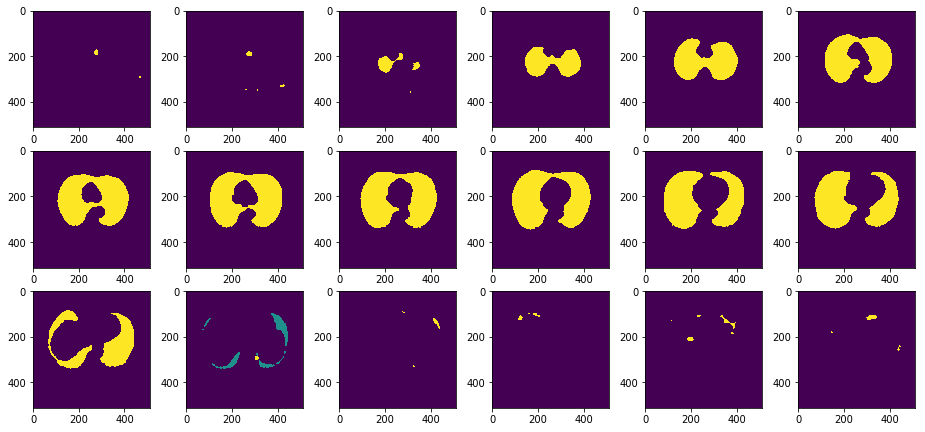

In [98]:
p = np.load('data/benign012.npy').all()
mask = p['mask']
roi = p['tag'][:,:,:,ROI]
num_slices = mask.shape[0]
plt.figure(figsize=(16, 12*((num_slices-1) / 6) + 12))
for i in range(mask.shape[0]):
    image = (roi[i] * 1) + ((mask[i] >0) * 2)
    plt.subplot((num_slices-1 / 6) +1, 6, i+1)
    plt.imshow(image)
plt.show()

In [105]:
stats

{'missed': ['data/malign094.npy',
  'data/malign095.npy',
  'data/malign102.npy',
  'data/malign128.npy',
  'data/malign162.npy',
  'data/malign165.npy',
  'data/malign172.npy',
  'data/malign186.npy',
  'data/malign187.npy',
  'data/malign199.npy',
  'data/malign225.npy',
  'data/malign256.npy',
  'data/malign262.npy',
  'data/malign264.npy',
  'data/malign291.npy',
  'data/malign323.npy']}

In [113]:
for file in stats['missed']:
    fcontent = np.load(file)
    mask_3d= fcontent.all()['mask']
    dilated = ndimage.binary_dilation(mask_3d, iterations=1)
    roi = ndimage.binary_dilation(fcontent.all()['tag'][:,:,:,ROI], iterations=0)
    covered = np.sum(dilated & roi) / np.sum(dilated)
    print('file %s mask cover %.2f%%' % (file, covered))

file data/malign094.npy mask cover 1.00%
file data/malign095.npy mask cover 1.00%
file data/malign102.npy mask cover 1.00%
file data/malign128.npy mask cover 1.00%
file data/malign162.npy mask cover 1.00%
file data/malign165.npy mask cover 1.00%
file data/malign172.npy mask cover 1.00%
file data/malign186.npy mask cover 1.00%
file data/malign187.npy mask cover 1.00%
file data/malign199.npy mask cover 1.00%
file data/malign225.npy mask cover 1.00%
file data/malign256.npy mask cover 1.00%
file data/malign262.npy mask cover 1.00%
file data/malign264.npy mask cover 1.00%
file data/malign291.npy mask cover 1.00%
file data/malign323.npy mask cover 1.00%


In [122]:
ndimage.binary_dilation(np.array([[0,0,0,0,0],[0,0,0,0,0],[0,0,1,0,0],[0,0,0,0,0],[0,0,0,0,0]]), iterations=2)

array([[False, False,  True, False, False],
       [False,  True,  True,  True, False],
       [ True,  True,  True,  True,  True],
       [False,  True,  True,  True, False],
       [False, False,  True, False, False]], dtype=bool)

In [157]:
testdata = sorted(glob('testdata/*'))

In [167]:
sss = []
for file in testdata:
    fcontent = np.load(file)
    mask_3d= fcontent.all()['mask']
#    dilated = ndimage.binary_dilation(mask_3d, iterations=1)
    dilated = mask_3d > 0
    label = measure.label(dilated)
    region = measure.regionprops(label)
    region.sort(key = lambda r : -r.area)
    
    bbox = region[0].bbox
    size = np.array(bbox[3:]) - np.array(bbox[:3])
    
#    roi = ndimage.binary_dilation(fcontent.all()['tag'][:,:,:,ROI], iterations=1)
    roi = fcontent.all()['tag'][:,:,:,ROI]
    covered = np.sum(dilated & roi) / np.sum(dilated)
    string = 'file %s mask cover %.2f area: %d regions: %d max size: %d %d %d' % tuple([file, covered, region[0].area, len(region)] + list(size))
    print(string)
    sss.append(string)
    

file data/malign001.npy mask cover 1.00 area: 133 regions: 1 max size: 1 18 16
file data/malign002.npy mask cover 1.00 area: 1361 regions: 1 max size: 2 47 42
file data/malign003.npy mask cover 1.00 area: 1868 regions: 1 max size: 4 29 42
file data/malign004.npy mask cover 1.00 area: 950 regions: 1 max size: 3 30 33
file data/malign005.npy mask cover 0.83 area: 2277 regions: 1 max size: 4 43 36
file data/malign006.npy mask cover 1.00 area: 218 regions: 1 max size: 1 31 24
file data/malign007.npy mask cover 0.97 area: 434 regions: 2 max size: 2 22 26
file data/malign008.npy mask cover 1.00 area: 930 regions: 1 max size: 2 29 29
file data/malign009.npy mask cover 1.00 area: 920 regions: 1 max size: 1 36 46
file data/malign010.npy mask cover 0.98 area: 745 regions: 1 max size: 3 34 25
file data/malign011.npy mask cover 1.00 area: 311 regions: 1 max size: 2 22 19
file data/malign012.npy mask cover 1.00 area: 1859 regions: 1 max size: 5 46 49
file data/malign013.npy mask cover 1.00 area: 10

KeyboardInterrupt: 

In [163]:
for s in sss:
    print(s)

file data/malign001.npy mask cover 1.00 area: 467 regions: 1 max size: 3 20 18
file data/malign002.npy mask cover 1.00 area: 3748 regions: 1 max size: 4 49 44
file data/malign003.npy mask cover 1.00 area: 3425 regions: 1 max size: 6 31 44
file data/malign004.npy mask cover 1.00 area: 2079 regions: 1 max size: 5 32 35
file data/malign005.npy mask cover 0.95 area: 4442 regions: 1 max size: 6 45 38
file data/malign006.npy mask cover 1.00 area: 775 regions: 1 max size: 3 33 26
file data/malign007.npy mask cover 1.00 area: 1199 regions: 1 max size: 4 24 28
file data/malign008.npy mask cover 1.00 area: 2210 regions: 1 max size: 4 31 31
file data/malign009.npy mask cover 1.00 area: 2889 regions: 1 max size: 3 38 48
file data/malign010.npy mask cover 1.00 area: 1901 regions: 1 max size: 5 36 27
file data/malign011.npy mask cover 1.00 area: 843 regions: 1 max size: 4 24 21
file data/malign012.npy mask cover 1.00 area: 4267 regions: 1 max size: 7 48 51
file data/malign013.npy mask cover 1.00 are

In [128]:
fcontent = np.load(testdata[0])
mask_3d= fcontent.all()['mask']
dilated = ndimage.binary_dilation(mask_3d, iterations=2)
label = measure.label(dilated)
region = measure.regionprops(label)
region.sort(key = lambda r : -r.area)

In [134]:
big = region[0]

In [147]:
big.bbox

(9, 236, 202, 16, 266, 231)

In [148]:
len(region)

1

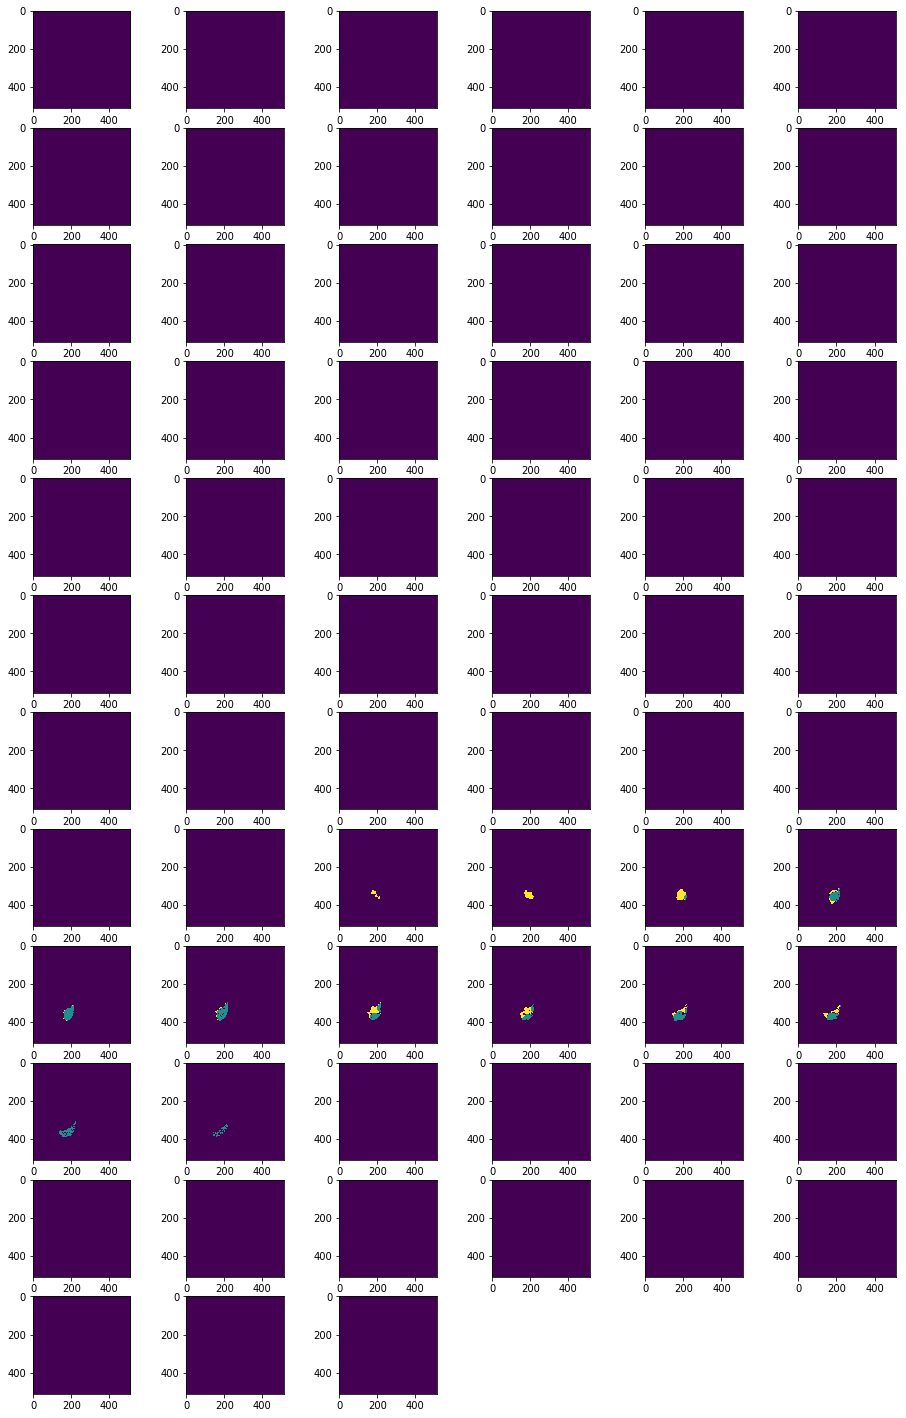

In [156]:
p = np.load('testdata/test012.npy').all()
mask = p['mask']
roi = p['tag'][:,:,:,ROI]
num_slices = mask.shape[0]
plt.figure(figsize=(16, 12*((num_slices-1) / 6) + 12))
for i in range(mask.shape[0]):
    image = ((mask[i] > 0) * 1) + ((mask[i] > 0) & roi[i])
    plt.subplot((num_slices-1 / 6) +1, 6, i+1)
    plt.imshow(image)
plt.show()